In [1]:
import numpy as np
import gym
from hiive.mdptoolbox import example, mdp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
#Creating a grid map of 4X4,10X10 and 50X50, which represent small,medium and large states
TERM_STATE_MAP = {
    "4x4": [5, 7, 11, 12],
    "8x8": [19, 29, 35, 41, 42, 46, 49, 52, 54, 59],
    "50x50": [122, 369, 501, 764, 892, 1197, 1354, 1578, 1943, 2221]}

GOAL_STATE_MAP = {
    "4x4": [15],
    "8x8": [63],
    "50x50": [2499]
}
cmap = 'cool'

def visualize_env(env, name, title=None):
    shape = (int(np.sqrt(env.observation_space.n)), int(np.sqrt(env.observation_space.n)))
    M = shape[0]
    N = shape[1]
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            state_index = i * N + j
            if state_index < env.observation_space.n:  # Ensure the index is within bounds
                if state_index in TERM_STATE_MAP[name]:
                    arr[i, j] = 0.25
                elif state_index in GOAL_STATE_MAP[name]:
                    arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(N))
    ax.set_yticks(np.arange(M))
    ax.set_xticklabels(np.arange(N))
    ax.set_yticklabels(np.arange(M))
    ax.set_xticks(np.arange(-0.5, N, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, M, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            state_index = i * N + j
            if state_index < env.observation_space.n:  # Ensure the index is within bounds
                if state_index == 0:
                    ax.text(j, i, 'S', ha='center', va='center', color='k', size=18)
                elif state_index in TERM_STATE_MAP[name]:
                    ax.text(j, i, 'H', ha='center', va='center', color='k', size=18)
                elif state_index in GOAL_STATE_MAP[name]:
                    ax.text(j, i, 'G', ha='center', va='center', color='k', size=18)
                else:
                    ax.text(j, i, 'F', ha='center', va='center', color='k', size=18)
    fig.tight_layout()
    if title:
        ax.set_title(title)
    plt.show()
    
def visualize_policy(policy, shape, name, title=None):
    M = shape[0]
    N = shape[1]
    actions = np.asarray(policy).reshape(shape)
    mapping = {
        0: '←',
        1: '↓',
        2: '→',
        3: '↑'
    }
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                arr[i, j] = 0.25
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=18)
            else:
                ax.text(j, i, mapping[actions[i, j]], ha='center', va='center', color='k', size=18)

    if title:
        ax.set_title(title)
    plt.show()
    
def visualize_value(V, shape, name, title=None):
    V = np.asarray(V)
    M = shape[0]
    N = shape[1]
    fig, ax = plt.subplots(figsize=(18, 18))
    arr = V.reshape(shape)
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k')
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k')
            else:
                ax.text(j, i, '%.2f' % (arr[i, j]), ha='center', va='center', color='k')
    # fig.tight_layout()
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('State-value estimate', rotation=-90, va="bottom")
    if title:
        ax.set_title(title)
    plt.show()

In [3]:
# Unpacked from gym.unwrapped.P is a list of states. Each state has a dictionary [0,1,2,3]. Each dictionary
# contains a 4 part tuple [probability(?),new_state,reward,finished]
def getRewardProb(env, sz):
    sz = int(sz ** 2)
    r = np.zeros((4, sz, sz))
    p = np.zeros((4, sz, sz))
    envP = env.unwrapped.P
    for state in envP:
        for action in envP[state]:
            transitions = envP[state][action]
            total_prob = sum(trans[0] for trans in transitions)
            for trans in transitions:
                new_state = trans[1]
                trans_prob = trans[0] / total_prob  # Normalize probability
                reward = trans[2]
                p[action][state][new_state] += trans_prob
                r[action][state][new_state] += reward
    
    # Normalize transition probabilities
    for state in range(sz):
        for action in range(4):
            total_prob = np.sum(p[action][state])
            if total_prob != 0:
                p[action][state] /= total_prob

    return r, p

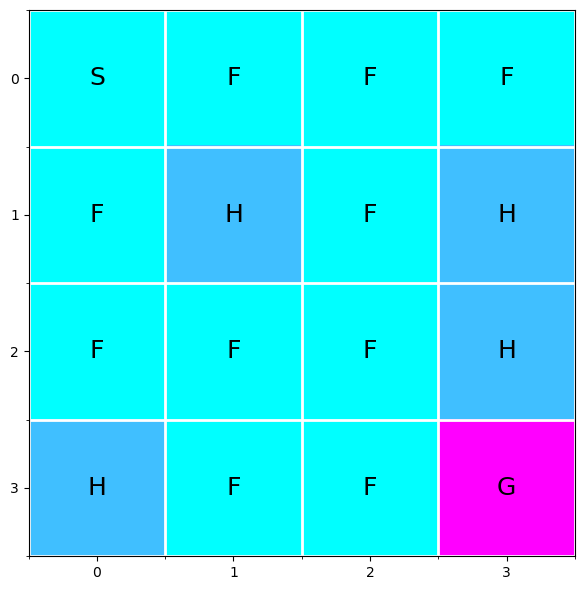

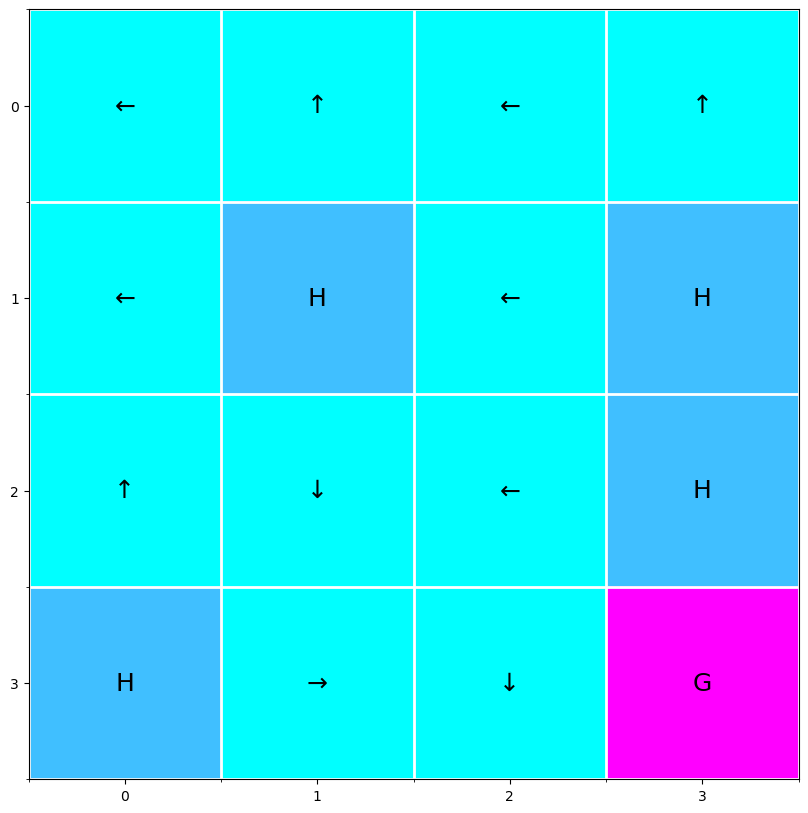

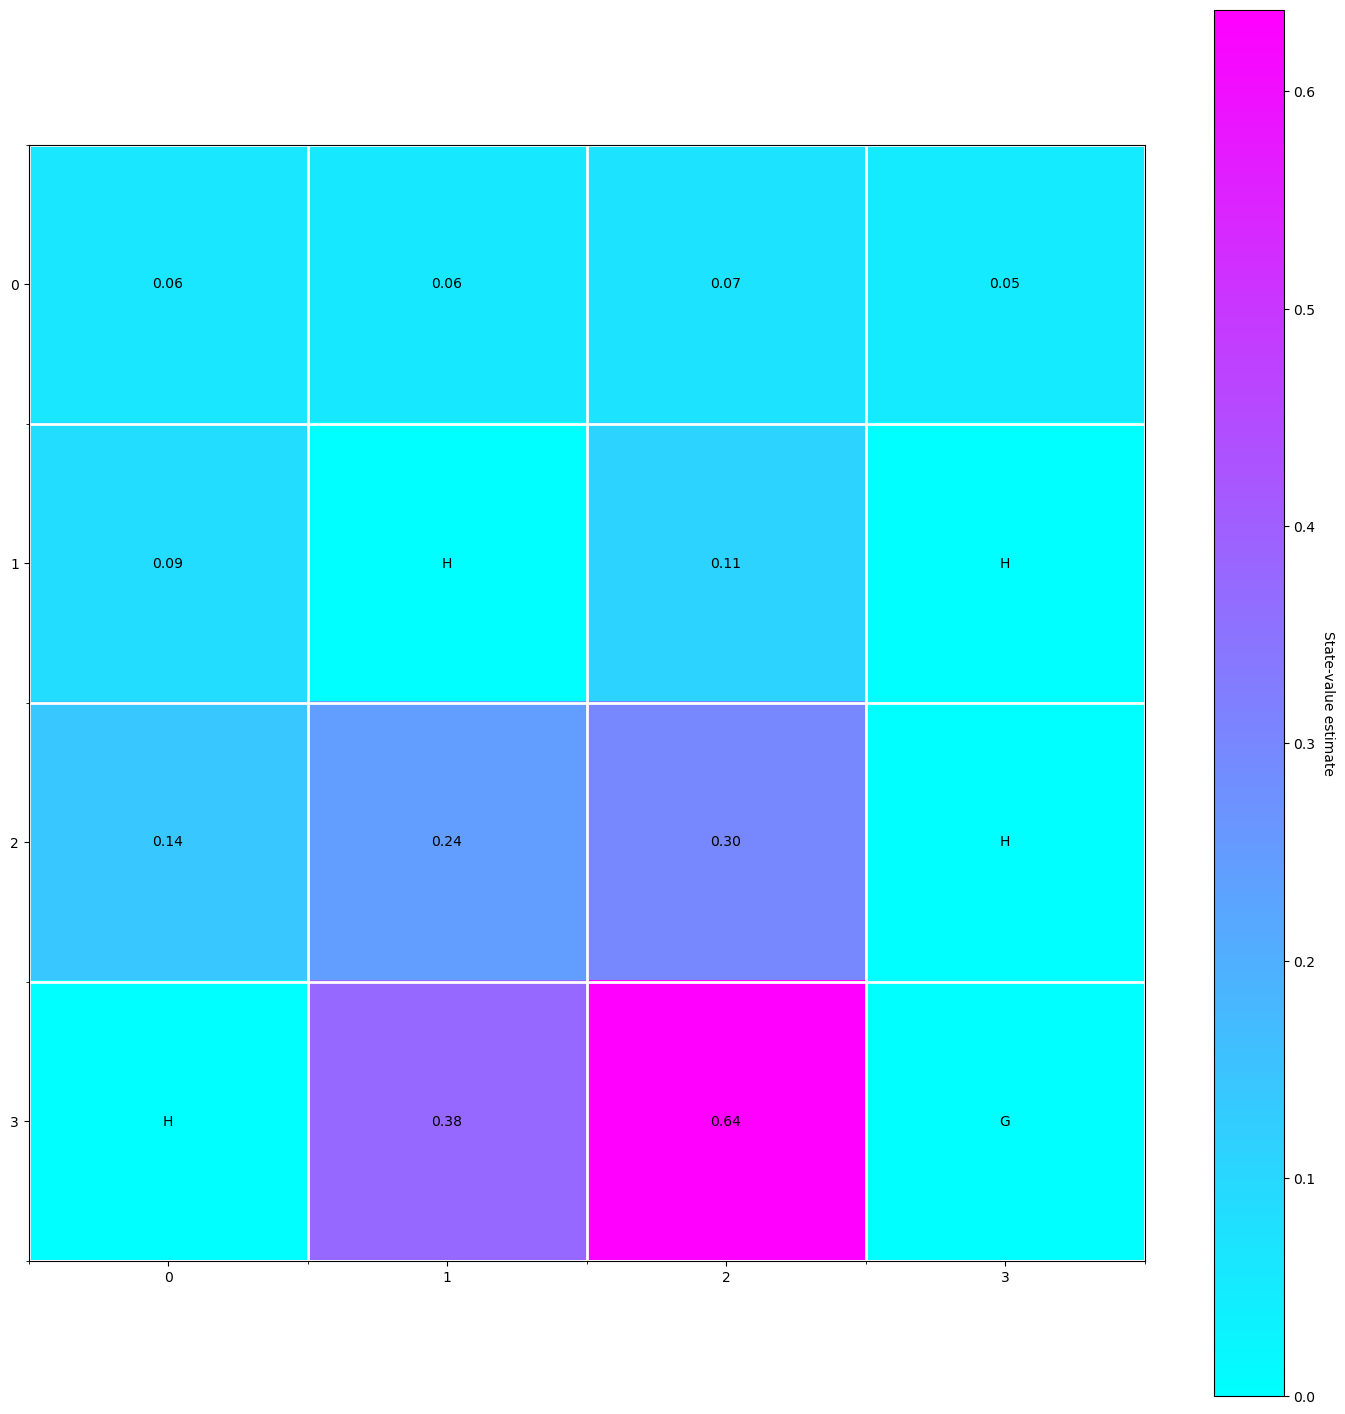

(0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
(0.06162274283994246, 0.05531399137342945, 0.06996222441595021, 0.051017029133017845, 0.0851946143178323, 0.0, 0.10976851693787402, 0.0, 0.13996615432409334, 0.24373109529624212, 0.29696299492872447, 0.0, 0.0, 0.37715398384339976, 0.6375395830635081, 0.0)


In [4]:
s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)
vi = mdp.ValueIteration(p, r, 0.9, max_iter=10000)
vi.run()
visualize_policy(vi.policy, sz, opt)
visualize_value(vi.V, sz, opt)
print(vi.policy)
print(vi.V)

In [5]:
def valueIterateGraph(p, r, value_iterate=True):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    gammas = np.arange(0.5, 1, 0.04)
    print(gammas)
    for gamma in gammas:
        if value_iterate:
            vi = mdp.ValueIteration(p, r, gamma)
        else:
            vi = mdp.PolicyIteration(p, r, gamma, max_iter=50)
        vi.run()
        stats = vi.run_stats
        iterations.append(list(range(1, len(stats) + 1)))
        max_vs.append([el['Max V'] for el in stats])
        mean_vs.append([el['Mean V'] for el in stats])
        errors.append([el['Error'] for el in stats])
        rewards.append([el['Reward'] for el in stats])

    f, ax = plt.subplots(2, 2, figsize=(15, 12))
    ax[0, 0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0, 0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i], 3)))
    ax[0, 0].legend()
    ax[0, 0].set_xlabel("# Iterations")

    ax[0, 1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0, 1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i], 3)))
    ax[0, 1].legend()
    ax[0, 1].set_xlabel("# Iterations")

    ax[1, 0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1, 0].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i], 3)))
    ax[1, 0].legend()
    ax[1, 0].set_xlabel("# Iterations")

    ax[1, 1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1, 1].plot(iterations[i], rewards[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i], 3)))
    ax[1, 1].legend()
    ax[1, 1].set_xlabel("# Iterations")
    plt.plot()

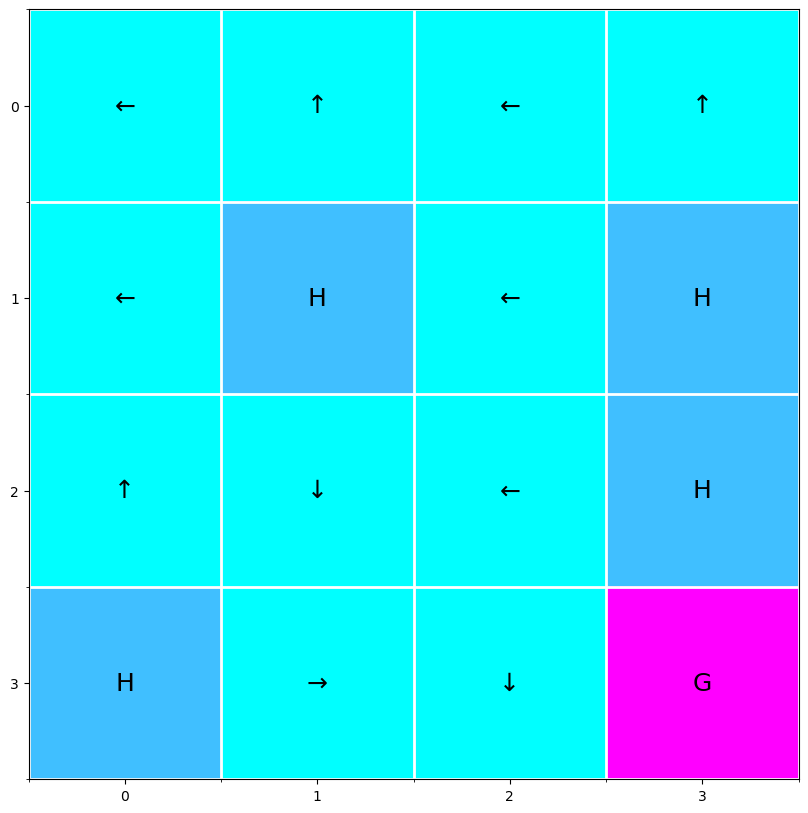

[0.5  0.54 0.58 0.62 0.66 0.7  0.74 0.78 0.82 0.86 0.9  0.94 0.98]
0.25661802291870117


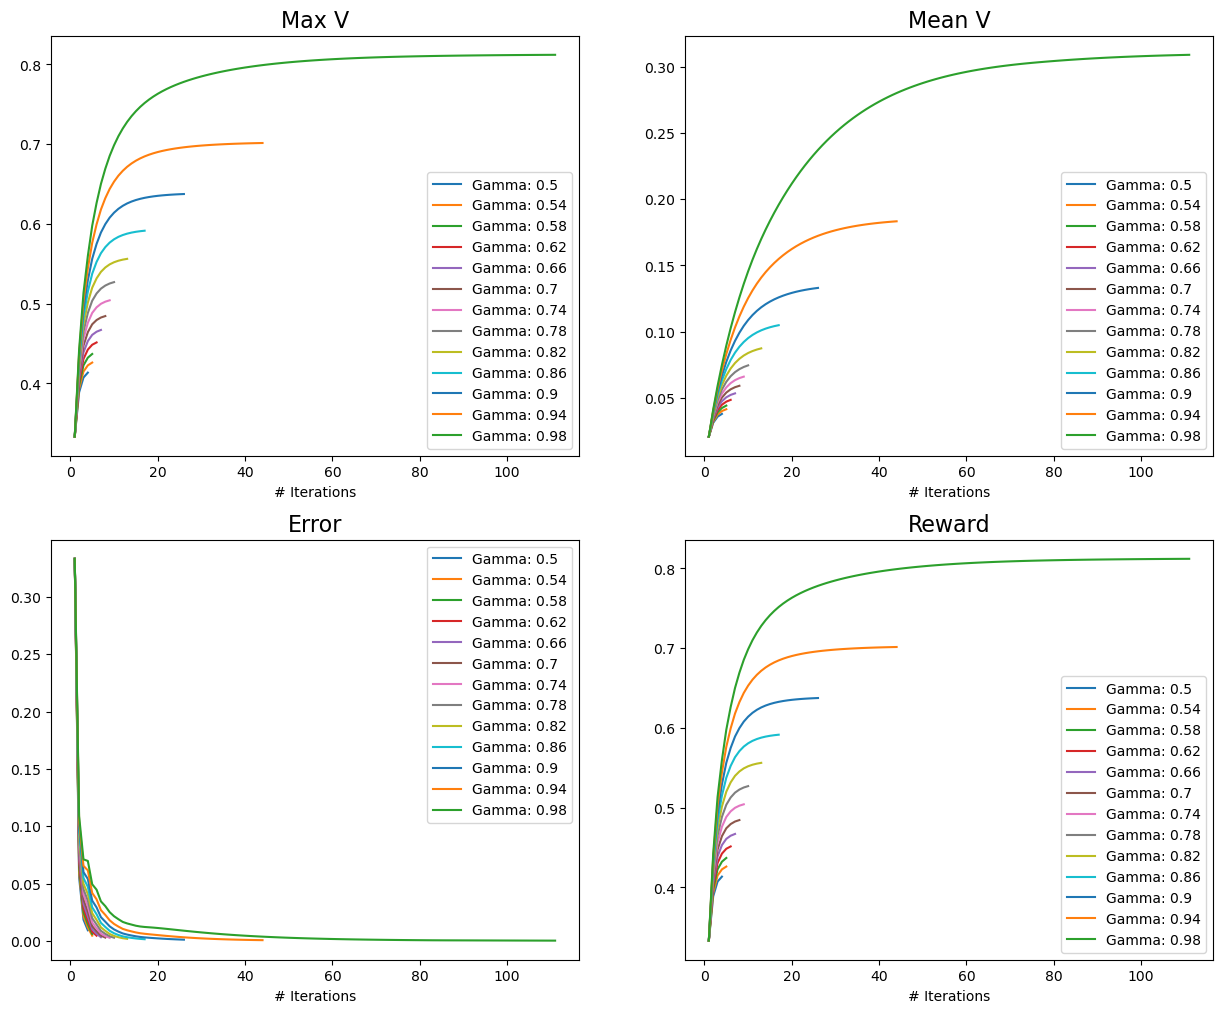

In [6]:
from time import time
tic = time()
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
r, p = getRewardProb(env,4)
vi = mdp.ValueIteration(p, r, 0.9, max_iter=10000)
vi.run()
visualize_policy(vi.policy, (4,4), "4x4")
valueIterateGraph(p, r)
print(time()-tic)

In [29]:
def runEpisodes(episodes, gamma, sz, max_iter=5000):
    total_successes = 0
    for _ in tqdm(range(episodes)):
        env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
        env.reset()
        r, p = getRewardProb(env, 4)

        vi = mdp.ValueIteration(p, r, gamma, max_iter=max_iter)
        vi.run()
        done = False
        state = 0
        policy = vi.policy
        total_reward = 0
        t = 0
        while not done:
            action = policy[state]
            next_state, reward, done, _, _ = env.step(action) 
            state = next_state  
            total_reward += reward
            if done:
                if reward == 1:
                    total_successes += 1
                break
            t += 1
    return total_successes

In [30]:
gammas = [el/100 for el in list(range(1, 100, 1))]
success_rates4 = []
for gamma in tqdm(gammas):
    episodes = 10
    total_successes = runEpisodes(episodes=episodes, gamma=gamma, sz=4)
    success_rates4.append(np.round(total_successes/episodes, 3))
print(success_rates4)


100%|██████████| 10/10 [00:00<00:00, 644.36it/s]

100%|██████████| 10/10 [00:00<00:00, 644.51it/s]

100%|██████████| 10/10 [00:00<00:00, 799.31it/s]

100%|██████████| 10/10 [00:00<00:00, 614.02it/s]

100%|██████████| 10/10 [00:00<00:00, 799.33it/s]

100%|██████████| 10/10 [00:00<00:00, 604.71it/s]

100%|██████████| 10/10 [00:00<00:00, 712.93it/s]

100%|██████████| 10/10 [00:00<00:00, 766.38it/s]

100%|██████████| 10/10 [00:00<00:00, 756.21it/s]

100%|██████████| 10/10 [00:00<00:00, 740.10it/s]

100%|██████████| 10/10 [00:00<00:00, 635.94it/s]

100%|██████████| 10/10 [00:00<00:00, 664.90it/s]

100%|██████████| 10/10 [00:00<00:00, 803.51it/s]

100%|██████████| 10/10 [00:00<00:00, 701.53it/s]

100%|██████████| 10/10 [00:00<00:00, 738.93it/s]

100%|██████████| 10/10 [00:00<00:00, 752.02it/s]

100%|██████████| 10/10 [00:00<00:00, 623.80it/s]

100%|██████████| 10/10 [00:00<00:00, 658.57it/s]

100%|██████████| 10/10 [00:00<00:00, 605.14it/s]

100%|██████████| 10/10 [00:00<00:00, 657.03it/s]



[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.4, 0.2, 0.2, 0.0, 0.2, 0.1, 0.1, 0.2, 0.1, 0.3, 0.4, 0.0, 0.4, 0.6, 0.5, 0.0, 0.2, 0.4, 0.2, 0.3, 0.4, 0.7, 0.5, 0.4, 0.3, 0.4, 0.6, 0.5, 0.3, 0.6, 0.6, 0.3, 0.7, 0.4, 0.5, 0.7, 0.5, 0.4, 0.5, 0.6, 0.7, 0.9, 0.9, 0.9, 0.8, 0.6, 0.8, 0.7, 0.5, 0.6, 0.8, 0.8, 0.9, 0.6, 0.9]


Text(0.5, 0, 'Gamma')

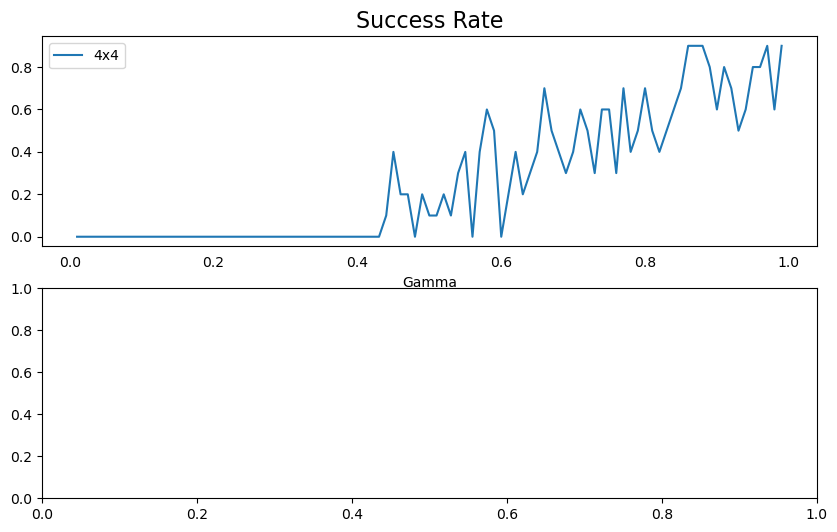

In [32]:
f, ax = plt.subplots(2, figsize=(10,6))
ax[0].set_title("Success Rate", fontsize=16)
ax[0].plot(gammas, success_rates4, label="4x4")
ax[0].tick_params(bottom=False)
ax[0].legend()
ax[0].set_xlabel("Gamma")

# 3. Policy Iteration

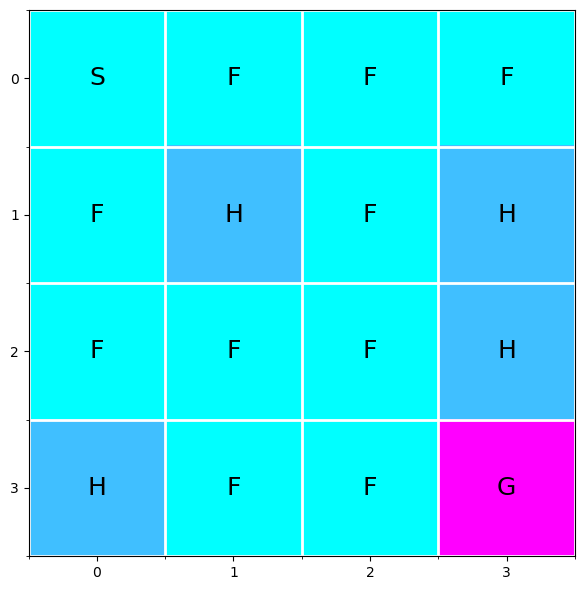

0.0020020008087158203
0.001508951187133789
0.0010077953338623047
0.0010013580322265625
0.0019981861114501953
0.004002094268798828


In [39]:
s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)
import time

tic = time.time()
vi1 = mdp.PolicyIteration(p, r, 0.5, max_iter=100)
vi1.run()
print(time.time()-tic)

tic = time.time()
vi1 = mdp.PolicyIteration(p, r, 0.6, max_iter=100)
vi1.run()
print(time.time()-tic)

tic = time.time()
vi1 = mdp.PolicyIteration(p, r, 0.7, max_iter=100)
vi1.run()
print(time.time()-tic)

tic = time.time()
vi1 = mdp.PolicyIteration(p, r, 0.8, max_iter=100)
vi1.run()
print(time.time()-tic)

tic = time.time()
vi1 = mdp.PolicyIteration(p, r, 0.9, max_iter=100)
vi1.run()
print(time.time()-tic)

tic = time.time()
vi2 = mdp.ValueIteration(p, r, 0.98, max_iter=100)
vi2.run()
print(time.time()-tic)

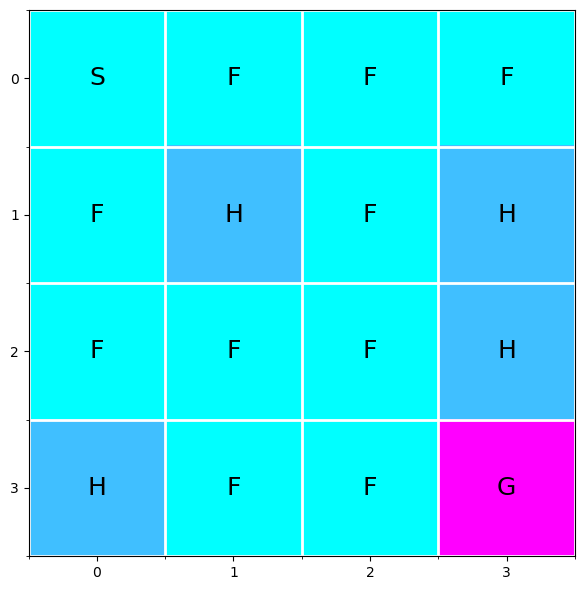

0.0020024776458740234
0.002000570297241211
0.0009980201721191406
0.0010006427764892578
0.0019989013671875
0.005033731460571289


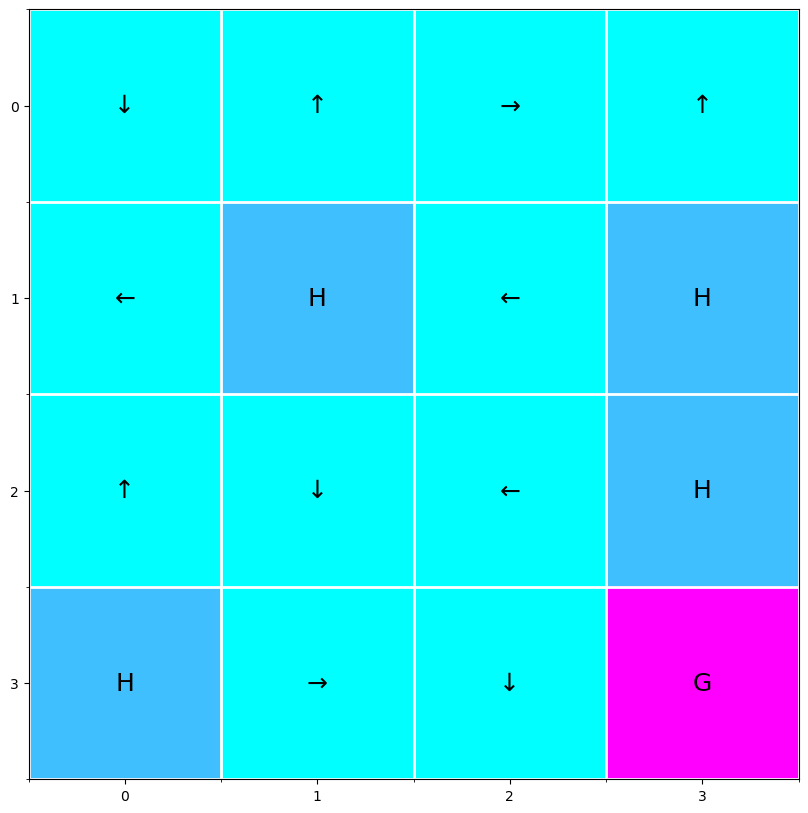

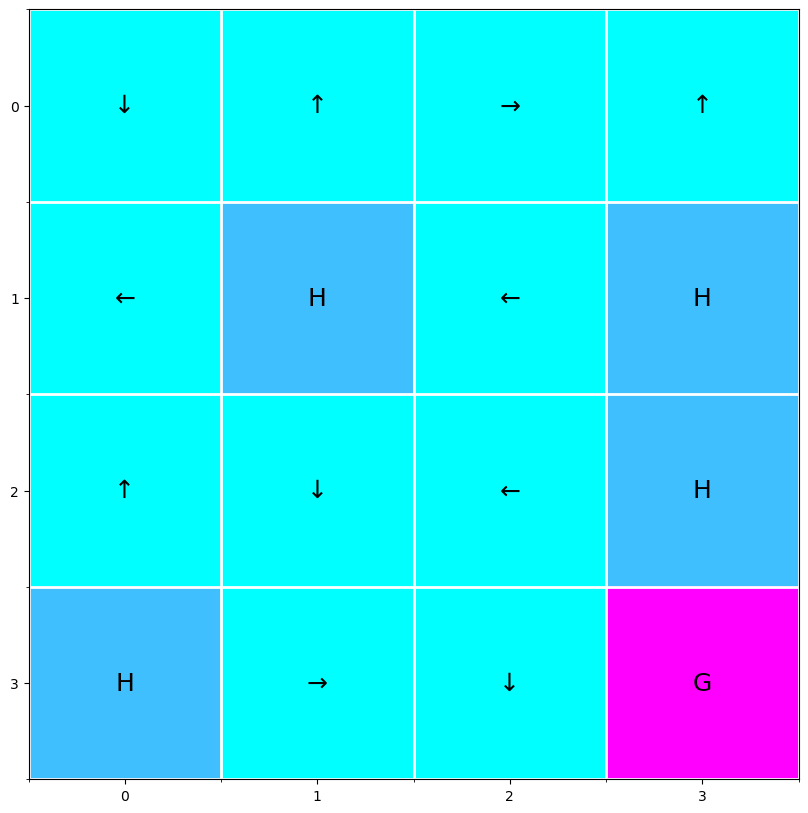

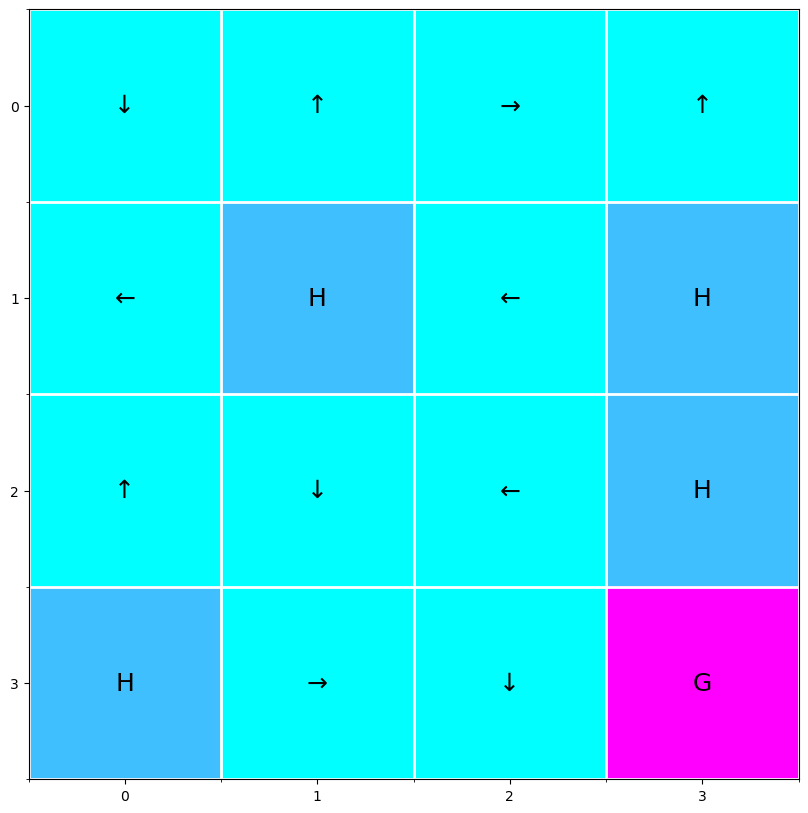

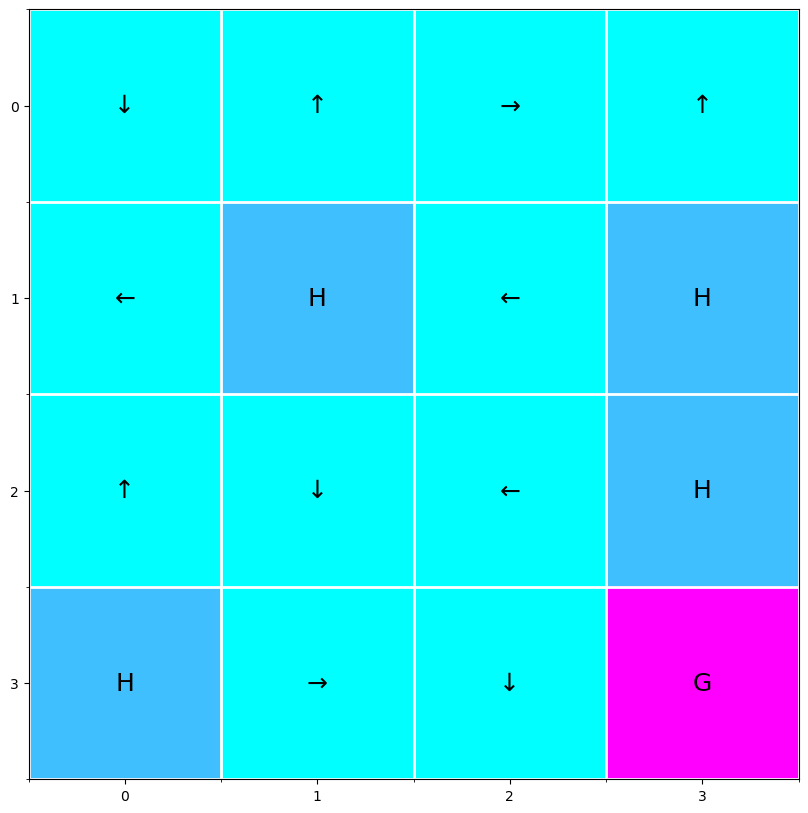

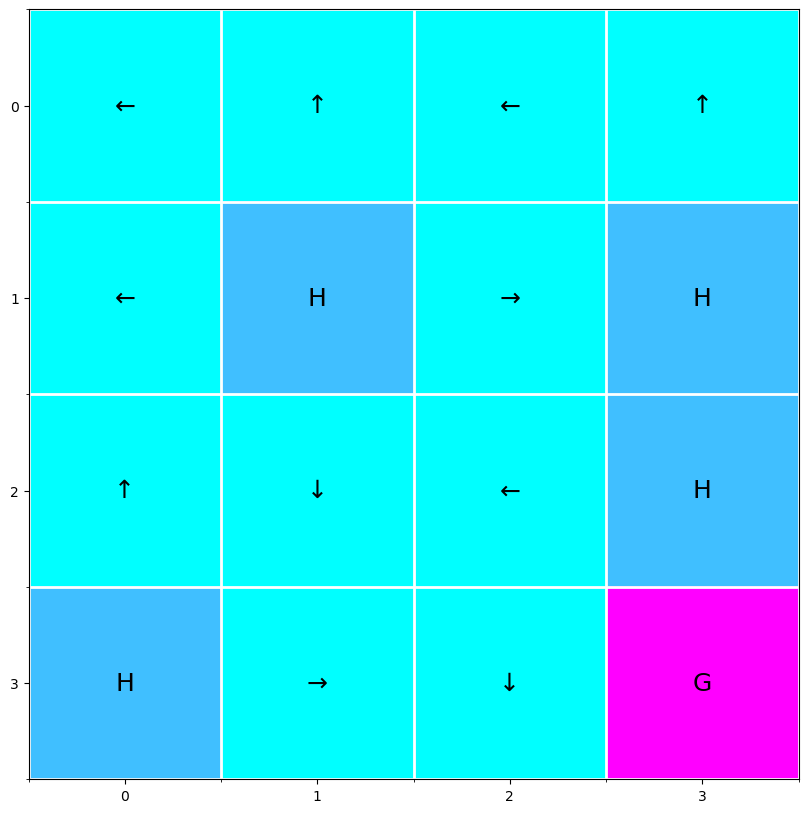

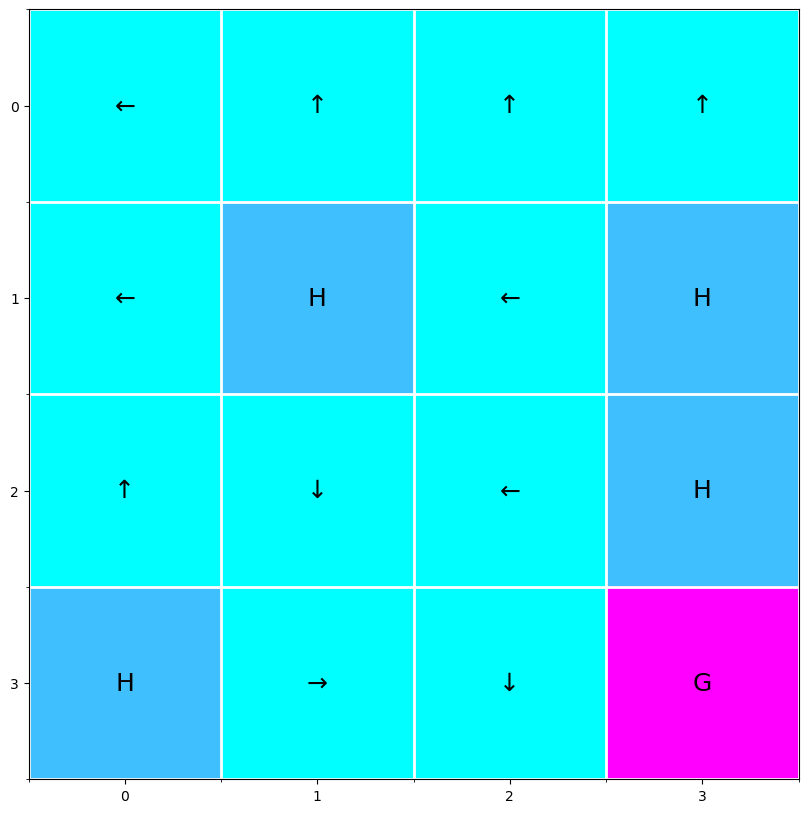

In [43]:
s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)
import time

tic = time.time()
vi0 = mdp.PolicyIteration(p, r, 0.5, max_iter=500)
vi0.run()
print(time.time()-tic)

tic = time.time()
vi1 = mdp.PolicyIteration(p, r, 0.6, max_iter=500)
vi1.run()
print(time.time()-tic)

tic = time.time()
vi2 = mdp.PolicyIteration(p, r, 0.7, max_iter=500)
vi2.run()
print(time.time()-tic)

tic = time.time()
vi3 = mdp.PolicyIteration(p, r, 0.8, max_iter=500)
vi3.run()
print(time.time()-tic)

tic = time.time()
vi4 = mdp.PolicyIteration(p, r, 0.9, max_iter=500)
vi4.run()
print(time.time()-tic)

tic = time.time()
vi5 = mdp.ValueIteration(p, r, 0.98, max_iter=500)
vi5.run()
print(time.time()-tic)
visualize_policy(vi0.policy, sz, opt)
visualize_policy(vi1.policy, sz, opt)
visualize_policy(vi2.policy, sz, opt)
visualize_policy(vi3.policy, sz, opt)
visualize_policy(vi4.policy, sz, opt)
visualize_policy(vi5.policy, sz, opt)

In [34]:
print("Policies match {}%".format(100*(np.array(vi1.policy) == np.array(vi2.policy)).sum()/np.array(vi1.policy).shape[0]))

Policies match 87.5%


[0.5  0.54 0.58 0.62 0.66 0.7  0.74 0.78 0.82 0.86 0.9  0.94 0.98]


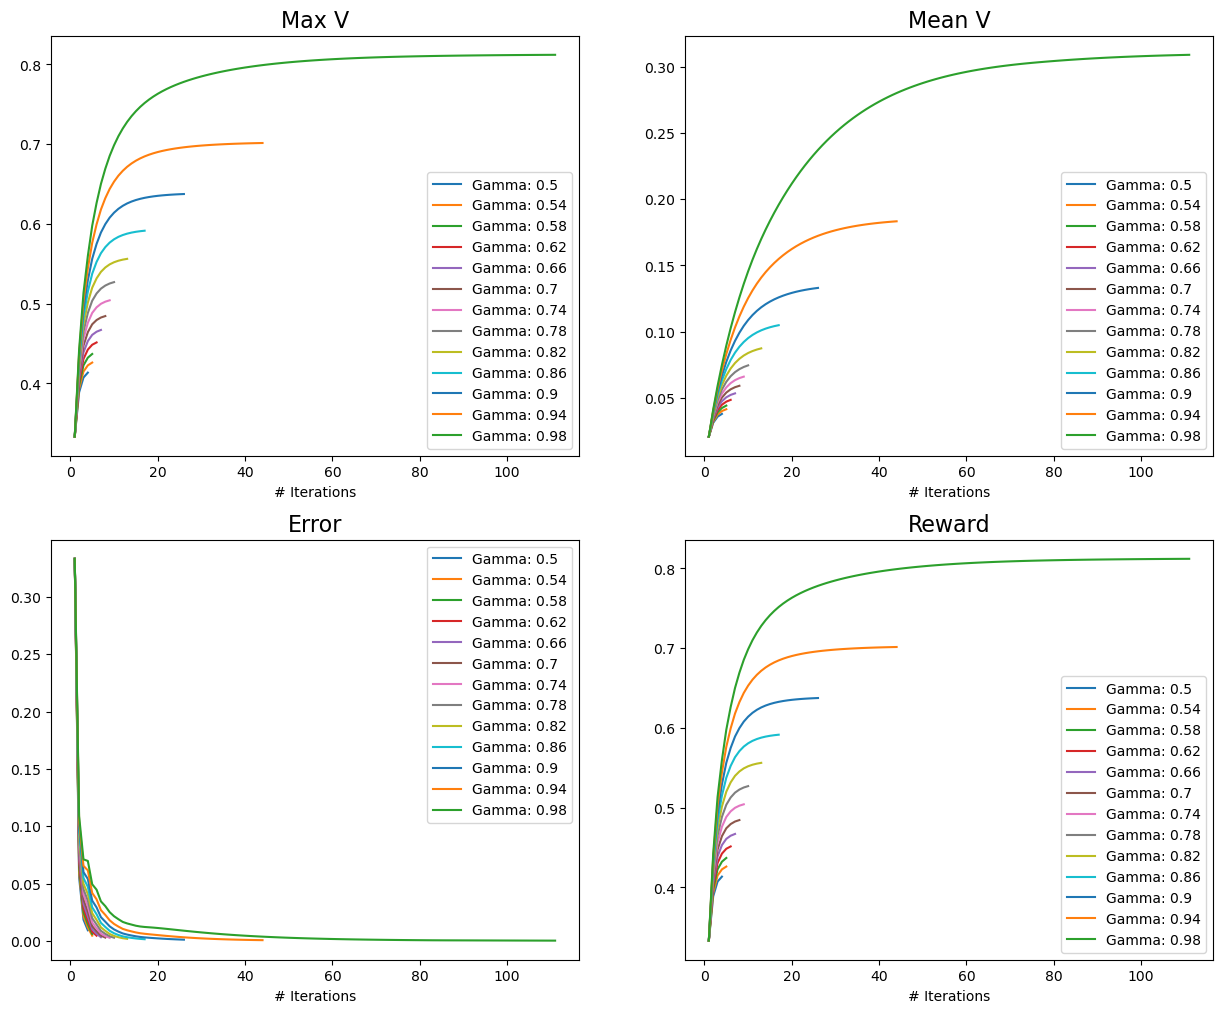

In [12]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
r, p = getRewardProb(env,4)
valueIterateGraph(p, r)

# 4. Q Learning 

26.45242667198181


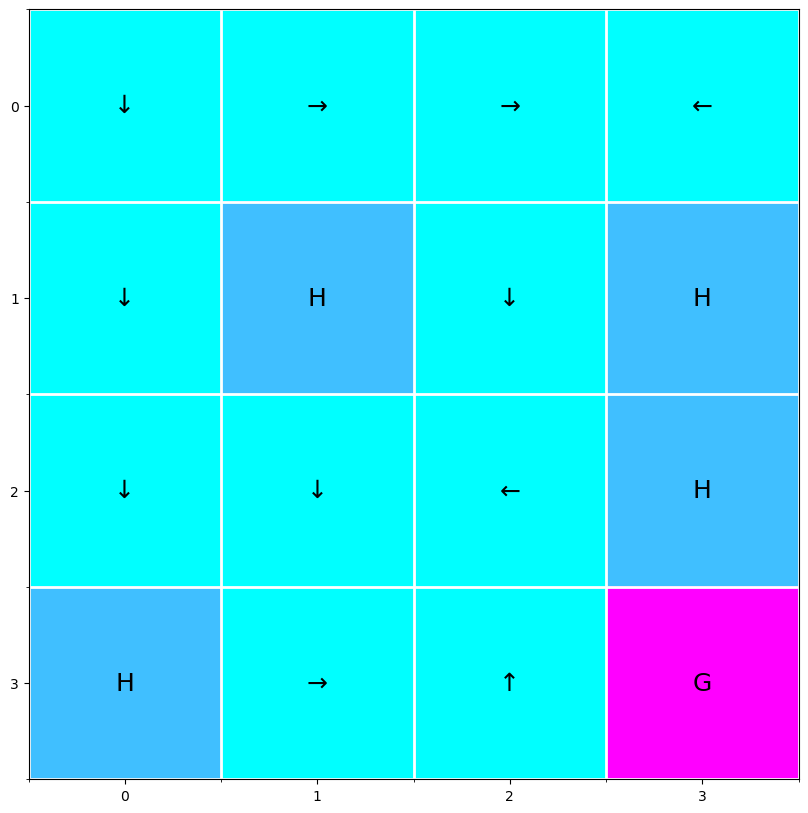

In [13]:
s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env.reset()
r, p = getRewardProb(env, s)

tic = time.time()
# vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.999, epsilon=1, epsilon_decay=0.99, n_iter=100000)
vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.99999, epsilon=1, epsilon_decay=0.9999, n_iter=1000000)
vi2.run()
print(time.time()-tic)

visualize_policy(vi2.policy, sz, opt)

In [44]:
def QLearnGraphGammas(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    gammas = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]
    for gamma in gammas:
        vi = mdp.QLearning(p, r, gamma=gamma, alpha=0.1, alpha_decay=0.99999, epsilon=1, epsilon_decay=0.9999, n_iter=10000000)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])

    f, ax = plt.subplots(2,2, figsize=(15,12))
    ax[0][0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    plt.plot()
    
def QLearnGraphEpsilons(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    epsilons = [0, 0.2, 0.4, 0.6, 0.8, 1]
    for epsilon in epsilons:
        vi = mdp.QLearning(p, r, gamma=0.9, alpha=0.1, alpha_decay=0.99999, epsilon=epsilon, epsilon_decay=0.9999, n_iter=10000000)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])

    f, ax = plt.subplots(2,2, figsize=(15,12))
    ax[0][0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Epsilons: {}".format(np.round(gammas[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Epsilons: {}".format(np.round(gammas[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Epsilons: {}".format(np.round(gammas[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Epsilons: {}".format(np.round(gammas[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    plt.plot()

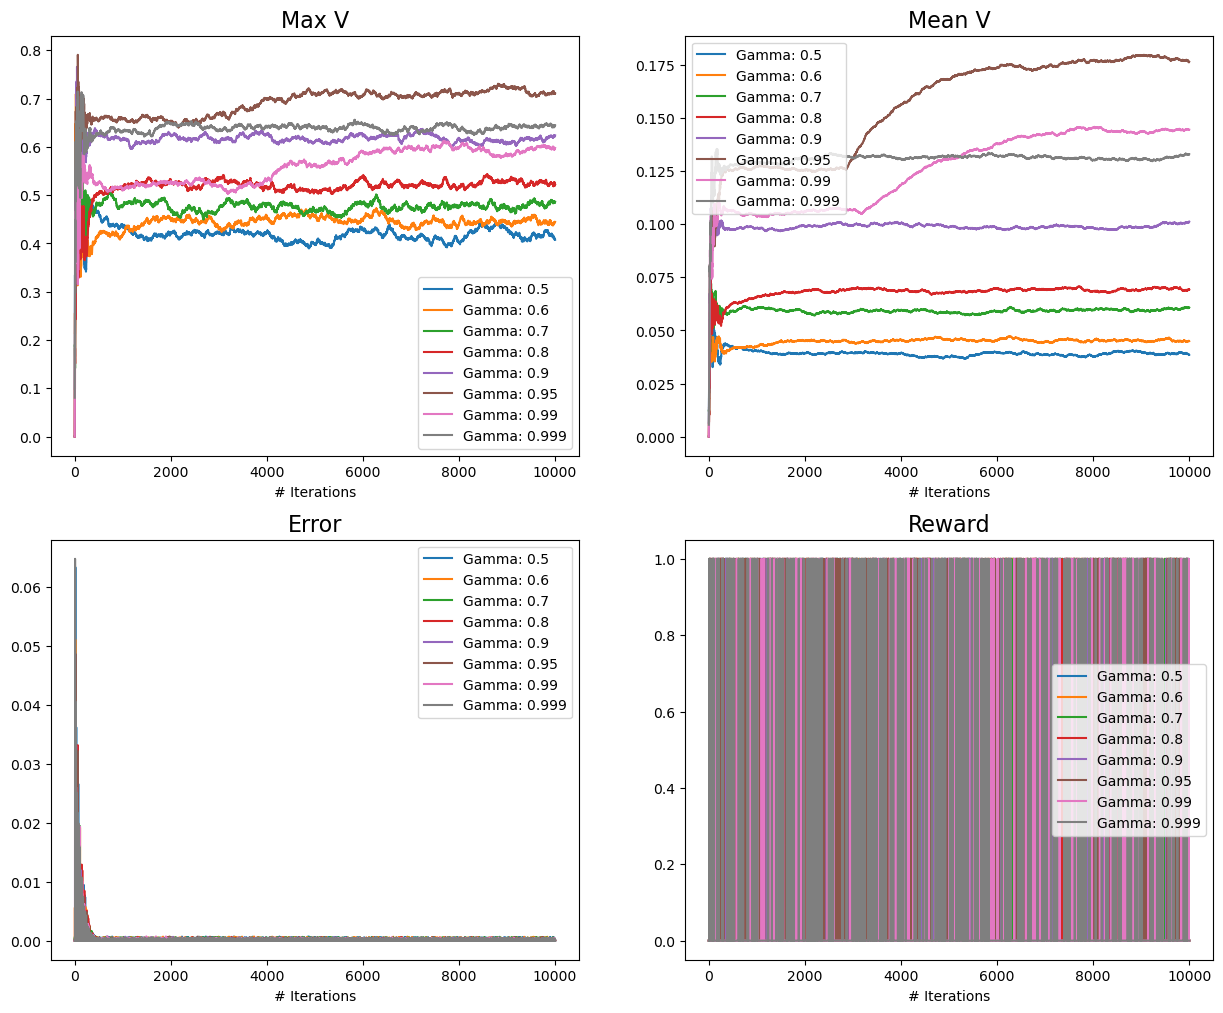

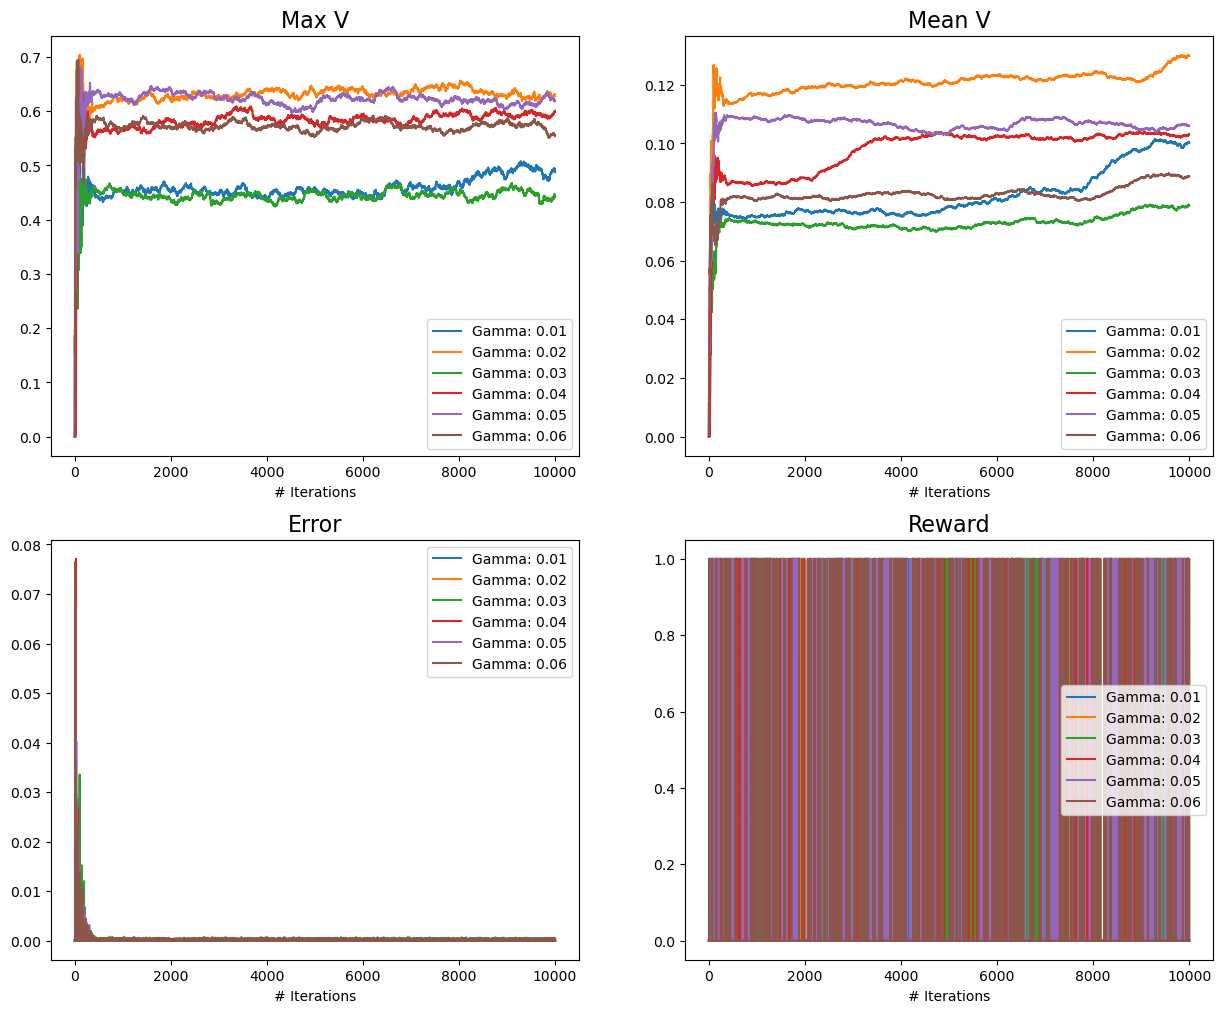

In [15]:
s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env.reset()
r, p = getRewardProb(env, s)
QLearnGraphGammas(p, r)
QLearnGraphEpsilons(p, r)